In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})
import tqdm
import sys
sys.path.append("../../")
from DynamicalSystems.koopman_regression import KernelRidgeRegression, PrincipalComponentRegression, ReducedRankRegression
from DynamicalSystems.kernels import Matern
from experiments.common_utils import *
from sklearn.model_selection import TimeSeriesSplit

[KeOps] Warning : OpenMP shared libraries not loaded, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


#### Standardizing dataset

In [2]:
df_path = 'full_dataframe'
df_pd = pd.read_pickle(df_path).interpolate().dropna()
#Remove rain measurements
RAIN_cols = df_pd.filter(regex="RAIN_*").columns
df_pd.drop(RAIN_cols, axis=1, inplace=True)
#Convert wind direction to angle
wd_subdf = df_pd.filter(regex="wd_*")
wd_cols = wd_subdf.columns
wd_sin = np.sin(wd_subdf).add_prefix("sin")
wd_cos = np.cos(wd_subdf).add_prefix("cos")
df_pd.drop(wd_cols, axis=1, inplace=True)
df_pd = pd.concat((df_pd, wd_sin, wd_cos), axis=1)
#Split by season of the year
months_split = df_pd.groupby(pd.Grouper(freq='M'))
seasonal_dfs = {
    'spring': [],
    'summer': [],
    'autumn': [],
    'winter': []
}

for n, g in months_split:
    if n.month in [3, 4, 5]:
        seasonal_dfs['spring'].append(g)
    elif n.month in [6, 7, 8]:
        seasonal_dfs['summer'].append(g)
    elif n.month in [9, 10, 11]:
        seasonal_dfs['autumn'].append(g)
    else:
        seasonal_dfs['winter'].append(g)

In [3]:
season = 'winter'
df, standardizing_parameters = split_by_measurement_and_normalize(pd.concat(seasonal_dfs[season]))

#### Selecting timestep, kernel, desired rank & regularizer

In [4]:
n_timesteps = 1 #In hours
history = 4 #In units of n_timesteps
average = False
X, Y, features_names = prepare_training_dataset(df, n_timesteps = n_timesteps, history = history, average = average, shift = 16)
num_samples = 7000
rank = 10
length_scale = np.float32(np.sqrt(X.shape[1]))
kernel = Matern(nu = 0.5, length_scale=length_scale)

### Cross Validation

In [5]:
tsCV = TimeSeriesSplit(n_splits=5, max_train_size=num_samples)
tikhonov_regs = np.geomspace(1e-7, 1e-1, 20)
estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression]
backend = 'cpu'

In [6]:
iterator = tikhonov_regs
error = np.zeros((len(iterator), len(estimators), 2))
for est_idx, estimator in enumerate(estimators):
    for iter_idx, iterate in tqdm.tqdm(enumerate(iterator), desc =estimator.__name__, total=len(iterator)):      
        _err = []
        for train_index, test_index in tsCV.split(X):
            X_train, Y_train = X[train_index], Y[train_index]
            X_test, Y_test = X[test_index], Y[test_index]
            if estimator == KernelRidgeRegression:
                model = estimator(kernel, tikhonov_reg = iterate)
            else:
                model = estimator(kernel, rank = rank, tikhonov_reg = iterate)
            model.fit(X_train, Y_train, backend = backend)
            _err.append(model.risk(X_test, Y_test))
        _err = np.array(_err)
        error[iter_idx, est_idx, 0] = np.mean(_err)
        error[iter_idx, est_idx, 1] = np.std(_err)

PrincipalComponentRegression:   0%|          | 0/20 [00:28<?, ?it/s]


KeyboardInterrupt: 

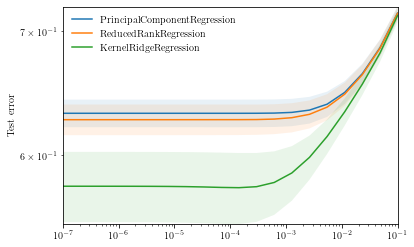

In [33]:
fig, ax = plt.subplots()
for idx, estimator in enumerate(estimators):       
    mean = error[:, idx, 0]
    std = error[:, idx, 1]
    ax.fill_between(iterator, mean - std, mean + std, alpha = 0.1)
    ax.plot(iterator, mean, '-', label = estimator.__name__)
    ax.margins(0)
    ax.legend(frameon=False)
ax.set_xlabel(r"Regularization strength $\gamma$")
ax.set_ylabel("Test error") 
ax.set_xscale('log')
ax.set_yscale('log')

### Forecasting

In [66]:
X_train, Y_train = X[:num_samples], Y[:num_samples]
tikhonov_reg = 1e-4 # From CV (see  above)
estimators = [PrincipalComponentRegression, ReducedRankRegression]
backend = 'keops'

time_offset = 25
idx_0 = num_samples - time_offset
n_steps = 100
ground_truth = Y[idx_0:(idx_0 + n_steps + 1)]

forecasts = []
times = np.arange(1, 10)
fitted_models = []
for estimator in estimators:
    print("Fitting " +estimator.__name__)
    if estimator == KernelRidgeRegression:
        model = estimator(kernel, tikhonov_reg = tikhonov_reg)
    else:
        model = estimator(kernel, rank = rank, tikhonov_reg = tikhonov_reg)
    model.fit(X_train, Y_train, backend = backend)
    model.modes()
    fitted_models.append(model)
    forecasts.append(model.forecast(ground_truth[:-1], times))
ground_truth = ground_truth[1:]

Fitting PrincipalComponentRegression
Fitting ReducedRankRegression


In [67]:
for model in fitted_models:
    name = type(model).__name__
    print(f"{name}:")
    print(" Train: {}".format(model.risk()))
    print(" Test: {}".format(model.risk(X[num_samples:], Y[num_samples:])))

Train PrincipalComponentRegression risk = 0.5809390755443362
Test PrincipalComponentRegression risk = 0.5923109648912339
Train ReducedRankRegression risk = 0.5779897746566292
Test ReducedRankRegression risk = 0.5898906802035031


In [68]:
def plot_forecast(ax, t, x, estimator_name, color, style = '-', alpha = 1):
    parsed_data, _ = get_measurement(x, measurement, features_names, history, standardizing_parameters)
    for j in range(parsed_data.shape[1]):
        ax.plot(t, parsed_data[:,j], '.',color=color, alpha = alpha*0.01, lw=0.5)
    ax.plot(t, parsed_data.mean(axis=1), style,color=color, alpha = alpha, label=estimator_name + ' ' + measurement)
print("Available measuements:")
for m_idx, m in enumerate(list(standardizing_parameters.keys())):
    print(f" {m_idx + 1}. {m}")

In [70]:
measurement = 'PM2.5'
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
hours = np.linspace(0, n_steps*n_timesteps, n_steps) - n_timesteps*time_offset

#### 1-step forward forecast Plot

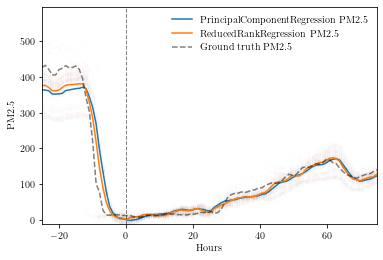

In [71]:
fig, ax = plt.subplots()
shift_idx = 0
for i in range(len(forecasts)):
    plot_forecast(ax, hours + shift_idx, forecasts[i][shift_idx], estimators[i].__name__, cycle[i], alpha = 1, style = '-')
plot_forecast(ax, hours, ground_truth, 'Ground truth', 'k', style='--', alpha = 0.5)

ax.axvline(x=0, color='k', linestyle='--', lw=1, alpha = 0.5)
ax.set_ylabel(measurement)
ax.set_xlabel('Hours')
ax.set_xlim(hours[0], hours[-1])
ax.margins(0)
ax.legend(frameon=False)

### Mode decomposition

In [91]:
estimator_idx = 1
modes = fitted_models[estimator_idx]._modes
evals = fitted_models[estimator_idx]._evals
revecs = fitted_models[estimator_idx]._revecs
obs_1 = "PM2.5"
obs_2 = "WSPM"

modes_1, fnames_1 = get_measurement(modes, obs_1, features_names, history, None)
modes_2, fnames_2 = get_measurement(modes, obs_2, features_names, history, None)

#Shunyi -2
station_idx = 5
station_name = fnames_1[station_idx].split("_")[1]
print(station_name)
modes_1_avg = modes_1[:,station_idx]
modes_2_avg = modes_2[:,station_idx]
c_1 = 'r'
c_2 = 'b'

Gucheng


In [87]:
print_timescale(evals, 24**-1, n_timesteps, 'Days')

Decay:62.09 Days
Decay:2.72 Days
Decay: 2.23 Days   Frequency: 28.82 Days
Decay: 1.5 Days    Frequency: 14.07 Days
Decay: 0.94 Days   Frequency: 6.54 Days
Decay: 0.7 Days    Frequency: 1.94 Days


Text(0, 0.5, 'Mode amplitude')

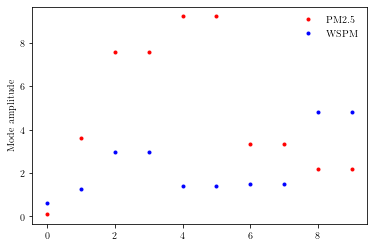

In [88]:
#plt.plot(np.abs(modes_1),c_1+'o', alpha=0.06);
#plt.plot(np.abs(modes_2),c_2+'o', alpha=0.06);
plt.plot(np.abs(modes_1_avg),c_1+'.', label=obs_1);
plt.plot(np.abs(modes_2_avg),c_2+'.', label=obs_2);
plt.legend(frameon=False)
plt.ylabel("Mode amplitude")
#plt.ylim(0, 20)

In [107]:
def causality_rel(idx, eigs, revecs, modes_1_avg, modes_2_avg, obs_1, obs_2, stride, n_timesteps, units, print_phi=True):
    if np.abs(np.angle(eigs[idx])) < 1e-15:
        if print_phi:
            print("Eigenvalue is real, dynamical mode is not oscillating")
        dphi = 0
    else:
        modes_1_avg = np.squeeze(modes_1_avg)
        modes_2_avg = np.squeeze(modes_2_avg)
        dphi = np.mean((np.angle((modes_1_avg*revecs*eigs)/(modes_2_avg*revecs*eigs))[:, idx]))*np.sign(np.angle(eigs[idx])) # dphi = phi_1 - phi_2 (phi_2 is the reference)
        if print_phi:
            if np.abs(dphi) < 1e-12:
                print(f"{obs_1} and {obs_2} are in phase")
            elif np.abs(np.abs(dphi) - np.pi) < 1e-12:
                print(f"{obs_1} and {obs_2} are in anti-phase")
            elif dphi > 0: # obs_1 is ahead of obs_2
                dt = np.around(stride*n_timesteps*dphi, decimals=2)
                print(f"{obs_1} comes first than {obs_2} by {dt} {units}")
            else: # obs_2 is ahead of obs_1
                dt = np.around(stride*n_timesteps*dphi, decimals=2)
                print(f"{obs_2} comes first than {obs_1} by {-dt} {units}")
    return dphi

In [113]:
for station_idx in range(len(fnames_1)):
    station_name = fnames_1[station_idx].split("_")[1]
    modes_1_avg = modes_1[:,station_idx]
    modes_2_avg = modes_2[:,station_idx]
    c_1 = 'r'
    c_2 = 'b'
    phase_diffs = []
    for idx in range(rank):
        dphi = causality_rel(idx, evals, revecs, modes_1_avg, modes_2_avg, obs_1, obs_2, 1, n_timesteps, 'Hours', print_phi=False)
        #print_timescale([evals[idx]], 1, n_timesteps, 'Hours') 
        if idx in [2,4,6]:
            phase_diffs.append(str(np.around(n_timesteps*dphi, decimals=2)) + " hrs. &")
        if idx in [0, 1]:
            phase_diffs.append(" - &")
        if idx in [8]:
            phase_diffs.append(str(np.around(n_timesteps*dphi, decimals=2)) + " hrs. \\\\")
    string = station_name + " & " + " ".join(phase_diffs)
    print(string)

Guanyuan &  - &  - & 2.88 hrs. & 2.79 hrs. & 1.54 hrs. & 2.38 hrs. \\
Aotizhongxin &  - &  - & 2.84 hrs. & 2.78 hrs. & 1.46 hrs. & 2.37 hrs. \\
Wanshouxigong &  - &  - & 2.89 hrs. & 2.5 hrs. & 1.63 hrs. & 2.38 hrs. \\
Tiantan &  - &  - & 3.01 hrs. & 2.81 hrs. & 1.59 hrs. & 2.34 hrs. \\
Nongzhanguan &  - &  - & 3.03 hrs. & 2.83 hrs. & 1.53 hrs. & 2.46 hrs. \\
Gucheng &  - &  - & 2.76 hrs. & 2.45 hrs. & 2.18 hrs. & 2.27 hrs. \\
Wanliu &  - &  - & 3.09 hrs. & -3.11 hrs. & 1.57 hrs. & 2.32 hrs. \\
Changping &  - &  - & 3.03 hrs. & 2.47 hrs. & 1.57 hrs. & 2.09 hrs. \\
Dingling &  - &  - & 3.0 hrs. & 2.48 hrs. & 1.39 hrs. & 1.99 hrs. \\
Huairou &  - &  - & 2.64 hrs. & 2.31 hrs. & 0.39 hrs. & 1.99 hrs. \\
Shunyi &  - &  - & 2.91 hrs. & 2.69 hrs. & 1.18 hrs. & 2.02 hrs. \\
Dongsi &  - &  - & 2.97 hrs. & 2.8 hrs. & 1.54 hrs. & 2.43 hrs. \\


In [50]:
data_1, feat_1 = get_measurement(Y_train, obs_1, features_names, history, None)
data_2, feat_2 = get_measurement(Y_train, obs_2, features_names, history, None)

idxs_groups = [[0], [1], [2,3], [4,5], [6,7],[8,9]]

partial_reconstruction_1 = []
partial_reconstruction_2 = []

Y_f = fitted_models[estimator_idx].forecast(X_train, 1.0)
reconstruction_1 = np.real(get_measurement(Y_f, obs_1, features_names, history, None)[0][:,-2])
reconstruction_2 = np.real(get_measurement(Y_f, obs_2, features_names, history, None)[0][:,-2])

for i in idxs_groups:
    Y_f = fitted_models[estimator_idx].forecast(X_train, 1.0, which=i)
    partial_reconstruction_1.append(get_measurement(Y_f, obs_1, features_names, history, None)[0][:,-2])
    partial_reconstruction_2.append(get_measurement(Y_f, obs_2, features_names, history, None)[0][:,-2])

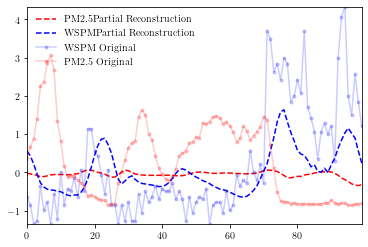

In [61]:
start = 500
delta = 100
idx =5

_d1  = partial_reconstruction_1[idx]
_d2  = partial_reconstruction_2[idx]
plt.plot(_d1[start:start + delta], c_1+'--', label=obs_1 + "Partial Reconstruction");
plt.plot(_d2[start:start + delta], c_2+'--', label=obs_2 + "Partial Reconstruction");

plt.plot(data_2[start:start + delta][:,-2], c_2+'.-', alpha=0.2, label=obs_2 + " Original");
plt.plot(data_1[start:start + delta][:,-2], c_1+'.-', alpha=0.2, label=obs_1 + " Original");
# plt.plot(a, c_2)
# plt.plot(b, c_1)

# plt.plot(reconstruction_1[start:start + delta], c_1+'-', alpha=0.3, label=obs_1 + " Reconstruction");
# plt.plot(reconstruction_2[start:start + delta], c_2+'-', alpha=0.3, label=obs_2 + " Reconstruction");
plt.legend(frameon=False)
#plt.ylim(0, 5)
plt.margins(0)